<a href="https://colab.research.google.com/github/AlekseiShevkoplias/Intragenic/blob/rubbish/find_repeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [18]:
import random

art_wins = []
lets = ["A", "C", "U", "G"]

def complement(s):
    comp = {"A":"U", "U":"A", "C":"G", "G":"C"}
    return("".join([comp[x] for x in s]))

def rev_complement(s):
    comp = {"A":"U", "U":"A", "C":"G", "G":"C"}
    return("".join([comp[x] for x in s][::-1]))

def gen_rand_string():
    """
    Со вставленным комплементом
    """
    s = ''
    for i in range(201):
        s += random.choice(lets)
    mid = s[97:104]
    i = random.randint(0, len(s))
    while (i > 90 and i < 105) or i > 193:
        i = random.randint(0, len(s))
    s = s[:i] + rev_complement(mid) + s[i+7:] ############
    return s

def gen_rubbish_string():
    """
    Без вставленного комплемента
    """
    s = ''
    for i in range(100):
        s += random.choice(lets)
    s += 'X'
    for i in range(100):
        s += random.choice(lets)
    return s

In [19]:
train_wins = [gen_rand_string() for _ in range(30000)]
test_wins = [gen_rand_string() for _ in range(5000)]
train_loses = [gen_rubbish_string() for _ in range(30000)]
test_loses = [gen_rubbish_string() for _ in range(5000)]

In [20]:

def recode_ans(l):
    bases_np        = {
                        "A": np.array([1, 0, 0, 0], dtype = np.float32),
                        "C": np.array([0, 1, 0, 0], dtype = np.float32),
                        "G": np.array([0, 0, 1, 0], dtype = np.float32),
                        "U": np.array([0, 0, 0, 1], dtype = np.float32),
                        "X": np.array([0, 0, 0, 0], dtype = np.float32)
                        }

    return bases_np[l]

def recode_data(s):
    bases_dict     = {"A": 0, "C": 1, "G": 2, "U": 3, "X": 4}
    bases_list = ["A", "C", "G", "U", "X"]
    seq_np = np.zeros((len(s), 4), dtype = np.float32) 
    for index in range(len(s)):
        base = s[index]
        if base in bases_list:
            channel = bases_dict[base]
            seq_np[index, channel] = 1
        else:
            if base == "N":
                continue
            print("alternative base", base, "!")
            return None
    return seq_np

def recode_data_new(s):
    bases_dict     = {"A": 0, "C": 1, "G": 2, "U": 3, "X": 4}
    bases_list = ["A", "C", "G", "U", "X"]
    mid = recode_data(s[97:100] + s[101:104])
    mid_addition = mid.flatten()

    seq_np = np.zeros((len(s), 28), dtype = np.float32) 
    for index in range(len(s)):
        base = s[index]
        if base in bases_list:
            channel = bases_dict[base]
            seq_np[index, channel] = 1
        else:
            if base == "N":
                continue
            print("alternative base", base, "!")
            return None
        for i in range(4, 28):
            seq_np[index, i] = mid_addition[i-4]
    return seq_np

In [21]:
def recode_samples(train, test):
    train_q = np.array([recode_data(x[:100] + "N" + x[101:]) for x in train])
    train_ans = np.array([recode_ans(x[100]) for x in train])

    test_q = np.array([recode_data(x[:100] + "N" + x[101:]) for x in test])
    test_ans = np.array([recode_ans(x[100]) for x in test])
    return train_q, train_ans, test_q, test_ans

train_q, train_ans, test_q, test_ans = recode_samples(train_wins, test_wins)

In [22]:
def show_arr(x):
    s = np.sum((i+1)*x[..., i::4] for i in range(4))
    for i in range(s.shape[1]):
        print(''.join((str(int(c)) for c in s[:, i])))
show_arr(train_q[100])
train_ans[100]

234444121443343224143244313311114242242223333432223331111234332341114431132122142141143142341422431402313244334234432223344313414322312231313243143334123333213443434324211243223233412421344411144434443


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


array([1., 0., 0., 0.], dtype=float32)

In [23]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Lambda, Add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [24]:
val_q, tr_q = train_q[:10000], train_q[10000:]
val_ans, tr_ans = train_ans[:10000], train_ans[10000:]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 201, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 201, 32)      1312        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 201, 32)      1312        input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 201, 4)       0           conv1d[0][0]                     
                                                                 input_1[0][0]                

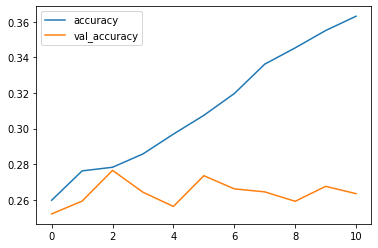

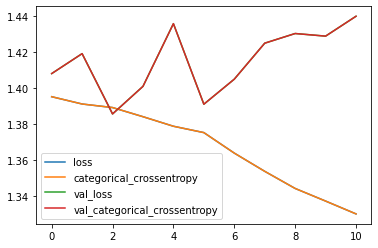

157/157 [==============================] - 0s 2ms/step - loss: 1.3844 - accuracy: 0.2848 - categorical_crossentropy: 1.3844


In [25]:
ms = []

def run_model():
    inp = Input((201, 4))
    cur_p = Conv1D(filters=32, kernel_size=10, padding='SAME')(inp)
    cur_p2 = Conv1D(filters=32, kernel_size=10, padding='SAME')(inp)
    cur = Attention()([cur_p, inp, cur_p2])
    cur = Flatten()(cur)
    cur = Dense(4, activation='softmax')(cur)
    model = Model(inp, cur)

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])    
    model.summary()

    es = EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)
    callbacks = []
    callbacks.append(es)

    history = model.fit(tr_q, tr_ans, epochs=40,  batch_size=32, validation_data=(val_q, val_ans), callbacks=callbacks, verbose=1)
    
    def show(history, acc_on=True):
        for k, v in history.history.items():
            if int('acc' not in k) + int(acc_on) == 1:
                plt.plot(v, label=k)
        plt.legend()
        plt.show()
    show(history, True)
    show(history, False)

    ms.append(model)
    loss, test_acc, test_cat = model.evaluate(test_q, test_ans, verbose=1)
    return test_acc

accs = [run_model() for _ in range(1)]